#### How it Works
Like permutation importance, partial dependence plots are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way.

In our soccer example, teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features.

To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the match"). But we repeatedly alter the value for one variable to make a series of predictions. We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [14]:
data = pd.read_csv('./input/fifa-2018-match-statistics/FIFA 2018 Statistics.csv')
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [15]:
y = (data['Man of the Match'] == 'Yes')   # Convert from string 'Yes'/'No' to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

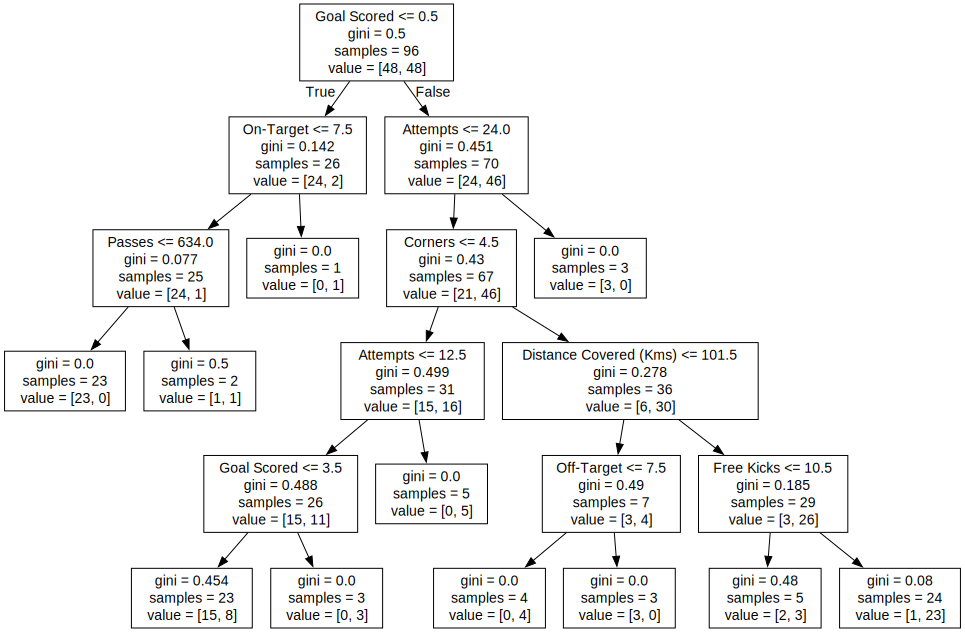

In [17]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

As guidance to read the tree:

Leaves with children show their splitting criterion on the top
The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.
Here is the code to create the Partial Dependence Plot using the scikit-learn library.

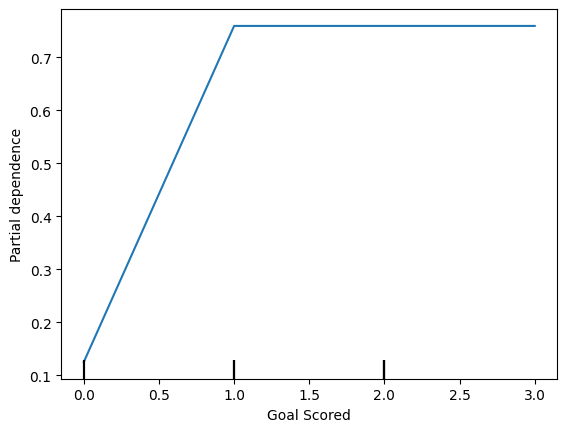

In [18]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
disp1 = PartialDependenceDisplay.from_estimator(tree_model, val_X, ['Goal Scored'])
plt.show()

The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

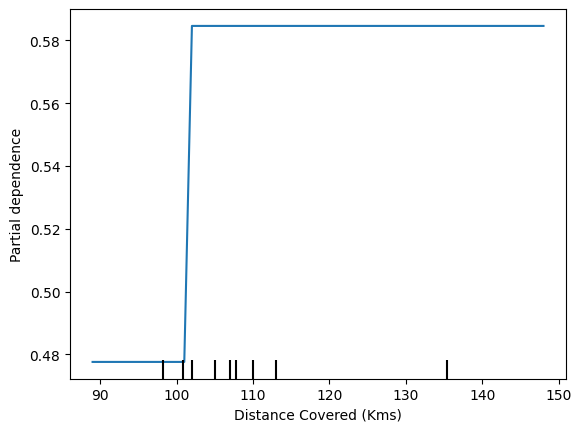

In [19]:
feature_to_plot = 'Distance Covered (Kms)'
disp2 = PartialDependenceDisplay.from_estimator(tree_model, val_X, [feature_to_plot])
plt.show()

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

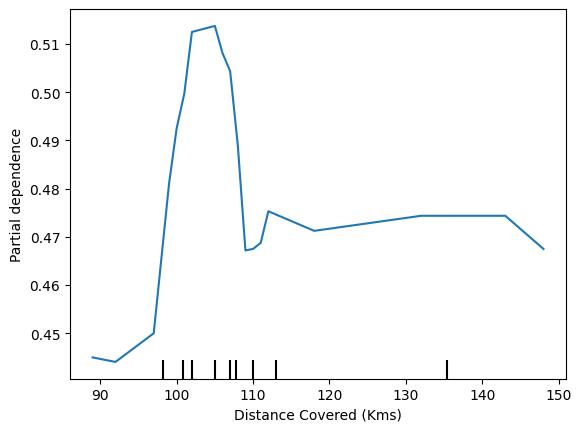

In [20]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

disp3 = PartialDependenceDisplay.from_estimator(rf_model, val_X, [feature_to_plot])
plt.show()

This model thinks you are more likely to win Man of the Match if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model. Though this dataset is small enough that we would be careful in how we interpret any model.

#### 2D Partial Dependence Plots
If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.

We will again use the Decision Tree model for this graph. It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.

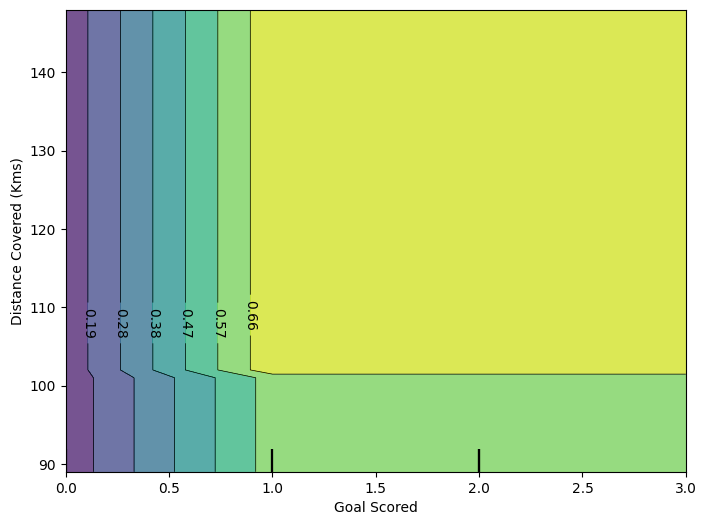

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('Goal Scored', 'Distance Covered (Kms)')]
# Similar to previous PDP plot except we use tuple of features instead of single feature
disp4 = PartialDependenceDisplay.from_estimator(tree_model, val_X, f_names, ax=ax)
plt.show()

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?

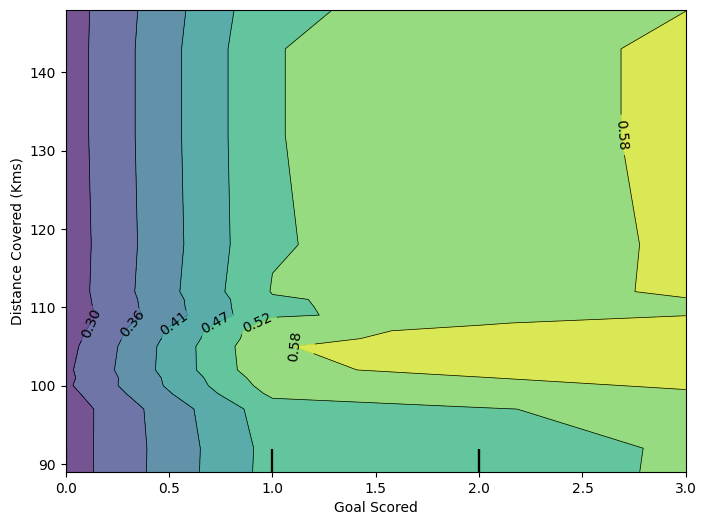

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
disp5 = PartialDependenceDisplay.from_estimator(rf_model, val_X, f_names, ax=ax)
plt.show()